In [52]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os, time
import keras
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from keras.utils import to_categorical
import os
print(os.listdir("../input"))
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
import matplotlib.pyplot as plt

[]


In [18]:
! pip install -q tensorflow-model-optimization


In [19]:
import tensorflow_model_optimization as tfmot

In [20]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [21]:
x_train.shape , y_train.shape, x_test.shape, y_test.shape


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [22]:
x_train = np.dstack([x_train.reshape(-1,784)]*3).reshape(-1,28,28,3)
x_test = np.dstack([x_test.reshape(-1,784)]*3).reshape(-1,28,28,3)
x_train.shape , x_test.shape


((60000, 28, 28, 3), (10000, 28, 28, 3))

In [23]:
from keras.preprocessing.image import img_to_array, array_to_img
x_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_train])
x_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_test])

x_train.shape, x_test.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

In [24]:
# Normalise the data and change data type
x_train = x_train / 255.
x_test = x_test / 255.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [25]:
# Converting Labels to one hot encoded format
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [26]:
# Splitting train data as train and validation data
x_train,x_valid,train_label,valid_label = train_test_split(x_train,
                                                           y_train_one_hot,
                                                           test_size=0.2,
                                                           random_state=13
                                                           )

In [27]:
x_train.shape,x_valid.shape,train_label.shape,valid_label.shape

((48000, 48, 48, 3), (12000, 48, 48, 3), (48000, 10), (12000, 10))

In [28]:
nbr_of_clases = 10

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.applications.resnet50 import ResNet50



In [30]:
Res = ResNet50(weights='imagenet',include_top = False, pooling = 'avg')

Res.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [31]:
BATCH_SIZE = 16
train_features = Res.predict(np.array(x_train), batch_size=BATCH_SIZE, verbose=1)
test_features = Res.predict(np.array(x_test), batch_size=BATCH_SIZE, verbose=1)
val_features = Res.predict(np.array(x_valid), batch_size=BATCH_SIZE, verbose=1)
for layer in Res.layers:
    layer.trainable = False

750/750 [==============================] - 10s 13ms/step


In [33]:
train_features_flat = np.reshape(train_features, (48000, 1*1*2048))
test_features_flat = np.reshape(test_features, (10000, 1*1*2048))
val_features_flat = np.reshape(val_features, (12000, 1*1*2048))

In [36]:
NB_TRAIN_SAMPLES = train_features_flat.shape[0]
NB_VALIDATION_SAMPLES = val_features_flat.shape[0]
NB_EPOCHS = 100

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(2048, activation='relu', input_dim=(1*1*2048)))
model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
model.add(tf.keras.layers.Dense(nbr_of_clases, activation='softmax'))

In [37]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['acc'])

In [38]:
reduce_learning = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    epsilon=0.0001,
    cooldown=2,
    min_lr=0)

eary_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

callbacks = [reduce_learning, eary_stopping]

In [39]:
# Train the the model
history = model.fit(
    train_features_flat,
    train_label,
    epochs=NB_EPOCHS,
    validation_data=(val_features_flat, valid_label),
    callbacks=callbacks
)

Epoch 1/100
1500/1500 [==============================] - 6s 4ms/step - loss: 0.9712 - acc: 0.6505 - val_loss: 0.6408 - val_acc: 0.7659
Epoch 2/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.6225 - acc: 0.7671 - val_loss: 0.6439 - val_acc: 0.7623
Epoch 3/100
1500/1500 [==============================] - 6s 4ms/step - loss: 0.5724 - acc: 0.7843 - val_loss: 0.5924 - val_acc: 0.7871
Epoch 4/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.5470 - acc: 0.7976 - val_loss: 0.6573 - val_acc: 0.7688
Epoch 5/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.5238 - acc: 0.8049 - val_loss: 0.5079 - val_acc: 0.8070
Epoch 6/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4997 - acc: 0.8141 - val_loss: 0.4834 - val_acc: 0.8227
Epoch 7/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4771 - acc: 0.8198 - val_loss: 0.5090 - val_acc: 0.8148
Epoch 8/100
1500/1500 [==============================] 

# Training

Train Accuracy --> 0.715708315372467
Train Accuracy --> 0.765916645526886


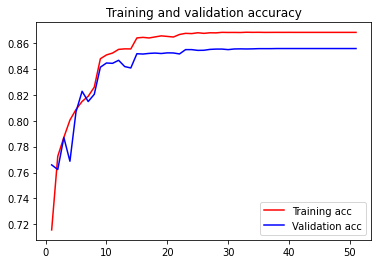

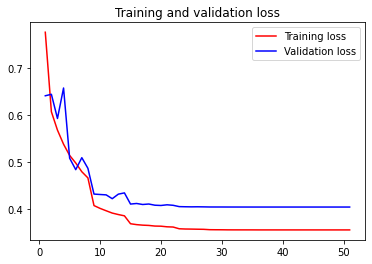

In [42]:
acc = history.history['acc']
print(f"Train Accuracy --> {acc[-1]}")
val_acc = history.history['val_acc']
print(f"Train Accuracy --> {val_acc[-1]}")
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [43]:
%time
_, baseline_model_accuracy = model.evaluate(
    test_features_flat, y_test_one_hot, verbose=0)

CPU times: user 17 µs, sys: 2 µs, total: 19 µs
Wall time: 22.9 µs


In [44]:
print('Baseline test accuracy:', baseline_model_accuracy)

Baseline test accuracy: 0.8508999943733215


In [45]:
import tempfile

In [46]:
_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

Saved baseline model to: /tmp/tmpvh0j7diu.h5


In [47]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude


batch_size = 120
epochs = 100


num_images = train_features_flat.shape[0] * (1)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs


pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)


model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_dense (P (None, 2048)              8390658   
_________________________________________________________________
prune_low_magnitude_leaky_re (None, 2048)              1         
_________________________________________________________________
prune_low_magnitude_dense_1  (None, 10)                40972     
Total params: 8,431,631
Trainable params: 4,216,842
Non-trainable params: 4,214,789
_________________________________________________________________


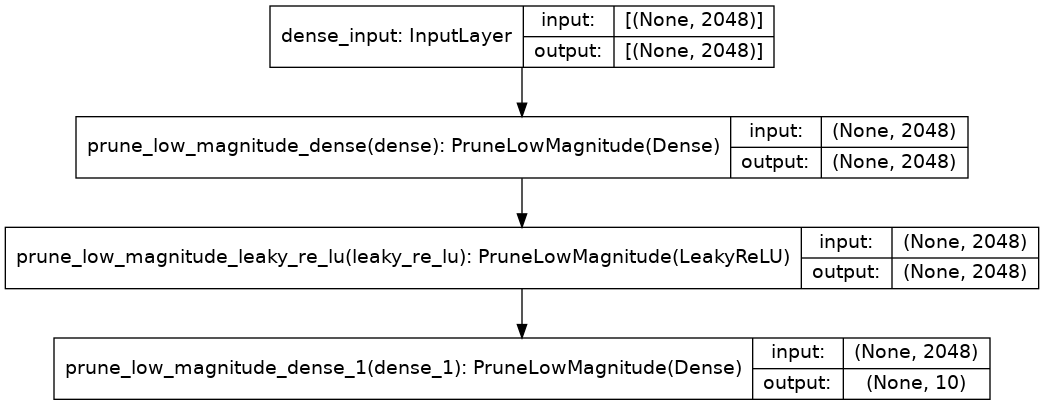

In [48]:
plot_model(model_for_pruning,show_shapes=True,show_layer_names=True)


In [49]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]
  
model_for_pruning.fit(train_features_flat, train_label,
                  batch_size=batch_size, epochs=epochs, validation_data=(val_features_flat, valid_label),
                  callbacks=callbacks)

Epoch 1/100
400/400 [==============================] - 6s 10ms/step - loss: 0.3852 - accuracy: 0.8565 - val_loss: 0.4328 - val_accuracy: 0.8390
Epoch 2/100
400/400 [==============================] - 3s 8ms/step - loss: 0.3838 - accuracy: 0.8562 - val_loss: 0.4107 - val_accuracy: 0.8517
Epoch 3/100
400/400 [==============================] - 4s 9ms/step - loss: 0.3786 - accuracy: 0.8592 - val_loss: 0.4284 - val_accuracy: 0.8403
Epoch 4/100
400/400 [==============================] - 3s 8ms/step - loss: 0.3737 - accuracy: 0.8607 - val_loss: 0.4107 - val_accuracy: 0.8529
Epoch 5/100
400/400 [==============================] - 3s 8ms/step - loss: 0.3752 - accuracy: 0.8609 - val_loss: 0.4188 - val_accuracy: 0.8447
Epoch 6/100
400/400 [==============================] - 4s 10ms/step - loss: 0.3581 - accuracy: 0.8656 - val_loss: 0.4155 - val_accuracy: 0.8497
Epoch 7/100
400/400 [==============================] - 3s 8ms/step - loss: 0.3657 - accuracy: 0.8603 - val_loss: 0.4206 - val_accuracy: 0.84

In [50]:
%time
_, model_for_pruning_accuracy = model_for_pruning.evaluate(
   test_features_flat, y_test_one_hot, verbose=0)

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 11.9 µs


In [51]:
print('Baseline test accuracy:', baseline_model_accuracy) 
print('Pruned test accuracy:', model_for_pruning_accuracy)


Baseline test accuracy: 0.8508999943733215
Pruned test accuracy: 0.8658000230789185


<h2> The Execution Time for the code reduced by half by applying the above code from 22.9 μs to 11.9 μs with a bit improve in accuracy</h2>